# Learned Data Augmentation

This tutorial gives an example for an application of the CPAB library.
This tutorial relies on different tensorflow functionalities, thus to run this demo, you need tensorflow installed.

Many machine learning algorithms are crucially dependent on the provided data. In many applications we face a massive shortcoming of labeled data. This problem is tackled by *data augmentation*, i.e. new data points are synthetically generated from old ones. Classically, people have used hand-crafted augmentation schemes to create new examples based on a priori assumptions about the data. For images this often means rotating, scaling or translating the images by small random values. 

These invariance assumptions, however, might or might not be justified and we potentially introduce deceptive variations. Following Hauberg et al. [1] we here look at the potential of *learned* data augmentation, i.e. creating new realistic data based on the variation in the known examples. In this tutorial which is based on Tobias Slott Jensen's master thesis, the idea is applied to time series. 

The learned data augmentation pipeline consists of three major parts. In order to understand the variation within the training data first step is to align (i.e. register) the images to each other. We use a diffeomorphic registration framework based on integrating stationary piecewise affine vector fields. We use the CPAB library by Nicki Skafte to do this. [citation?]
After registering the training images we build a statistical model over the transformations which describes the variation within the aligned image pairs. We then sample new transformations and apply them to existing images to create new data points. Lastly, the augmented datasets are used to train a one-nearest-neighbor classifier, a very simple machine learning model. We want to investigate how data augmentation influences the classification performance.

In [3]:
import random
from IPython.display import HTML


def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Show/hide cell'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

print('''This cell sets up the toggle functionality. I use this to hide uninteresting technical code in the following.
You can always untoggle it by clicking on the show/hide link.''')

hide_toggle()

This cell sets up the toggle functionality. I use this to hide uninteresting technical code in the following.
You can always untoggle it by clicking on the show/hide link.


In [11]:
import numpy as np
import pickle
import tensorflow as tf
from libcpab import Cpab, CpabAligner
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from matplotlib.animation import FFMpegWriter
from sklearn.neighbors import KNeighborsClassifier
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, BatchNormalization
from tensorflow.keras.optimizers import Adam

%matplotlib inline
%load_ext autoreload
%autoreload 2

print('\n This cell contains the neccessary imports.')

hide_toggle()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

 This cell contains the neccessary imports.


In [19]:
device = 'gpu'
with open('../data/BirdChicken', 'rb') as file:
    data = pickle.load(file)

# 1. Aligning the time series 
We start out by aligning the time series of the same class to each other. This is done by setting up a CPAB-transformer object T and optimizing its parameters $\theta$ such that it transforms one time series $s_1$ into another $s_2$, i.e. such that 
$$ \theta = argmin_{\alpha} \| T^\alpha (s_1) - s_2 \|^2  $$

In [22]:
def make_label_lookup(y_train):
    # make a dictionary of lists that, for each class,
    # contains indices of datapoints from that class in the training set
    classes = np.unique(y_train)
    class_indices = {}
    for label in classes:
        class_indices[label] = np.where(y_train == label)[0]
    return class_indices

def make_pairs_list(X_train, y_train):
    # get pairs of indices to be aligned
    class_lookup = make_label_lookup(y_train)
    classes = np.unique(y_train)
    transformation_pairs = {}
    for label in classes:
        datapoints_class = class_lookup[label]
        transformation_pairs_class = [(ts1, ts2) for ts1 in datapoints_class for ts2 in datapoints_class if ts2!=ts1]
        transformation_pairs[label] = np.array(transformation_pairs_class)
    return transformation_pairs

def align(X_train, transformation_pairs):
    # Optimize theta by aligning time series
    all_transformations = {}
    
    # Construct transformer and aligner
    T = Cpab(tess_size=[10], backend='tensorflow', device=device, zero_boundary=True)
    A = CpabAligner(T)
    
    # RUN OPTIMIZATION
    labels = transformation_pairs.keys()
    for label in labels:
        transformations_here = np.empty((0, 9))
        print('ALIGNING CLASS:', label)
        t_pairs = transformation_pairs[label]
        losses_before = []
        losses_after = []
        for (n,m) in t_pairs:
            x_n = X_train[n, :]
            x_n = np.expand_dims(np.expand_dims(x_n, 0), 2).astype(np.float32)
            x_n = T.backend.to(x_n, device=device)
            x_m = X_train[m, :]
            x_m = np.expand_dims(np.expand_dims(x_m, 0), 2).astype(np.float32)
            x_m = T.backend.to(x_m, device=device)
            print('-----' + str(n) + ',' + str(m) + '-----')
            
            theta_est = A.alignment_by_gradient(x_n, x_m, maxiter=200, lr=1e-3)
            transformations_here = np.append(transformations_here, theta_est, axis=0)

        all_transformations[label] = transformations_here        
    return all_transformations, losses_before, losses_after

print('''This cell contains all the functions we need for alignment.''')
hide_toggle()

This cell contains all the functions we need for alignment.


In [23]:
# Make the list of pairs we wnat to align from the training data
pairs = make_pairs_list(data['X_train'], data['y_train'])
# Then align those by optimization using CPAB. 
transformations, losses_before, losses_after = align(data['X_train'], pairs)

Alignment of samples:   4%|▍         | 8/200 [00:00<00:05, 34.70iters/s, loss=14.3]

ALIGNING CLASS: 0
-----0,2-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 45.77iters/s, loss=30.3]

-----0,6-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 45.13iters/s, loss=16.8]

-----0,7-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 45.66iters/s, loss=23.8]

-----0,9-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 46.23iters/s, loss=18.7]

-----0,11-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 42.16iters/s, loss=11.8]

-----0,14-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 45.76iters/s, loss=14.9]

-----2,0-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 45.22iters/s, loss=33.6]

-----2,6-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 45.29iters/s, loss=7.08]

-----2,7-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 46.48iters/s, loss=19.5]

-----2,9-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 43.02iters/s, loss=8.73]

-----2,11-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 46.20iters/s, loss=7.67]

-----2,14-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 41.59iters/s, loss=30.6]

-----6,0-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 39.71iters/s, loss=33.9]

-----6,2-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 46.19iters/s, loss=34]  

-----6,7-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 44.98iters/s, loss=24]  

-----6,9-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 43.42iters/s, loss=36.9]

-----6,11-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 45.47iters/s, loss=34.3]

-----6,14-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 45.15iters/s, loss=16.5]

-----7,0-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 46.02iters/s, loss=7.25]

-----7,2-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 46.72iters/s, loss=33]  

-----7,6-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 45.52iters/s, loss=18.4]

-----7,9-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 43.11iters/s, loss=6.07]

-----7,11-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 45.31iters/s, loss=7.4] 

-----7,14-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 44.19iters/s, loss=23.7]

-----9,0-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 45.94iters/s, loss=19.4]

-----9,2-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 46.40iters/s, loss=24.4]

-----9,6-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 42.91iters/s, loss=18.3]

-----9,7-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 42.60iters/s, loss=22.1]

-----9,11-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 45.04iters/s, loss=22.2]

-----9,14-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 43.35iters/s, loss=18.4]

-----11,0-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 42.54iters/s, loss=8.44]

-----11,2-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 44.44iters/s, loss=36.6]

-----11,6-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 46.39iters/s, loss=5.47]

-----11,7-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 39.87iters/s, loss=21.7]

-----11,9-----


Alignment of samples:   4%|▍         | 8/200 [00:00<00:04, 42.79iters/s, loss=8.23]

-----11,14-----


Alignment of samples:   4%|▍         | 9/200 [00:00<00:04, 45.05iters/s, loss=11.4]

-----14,0-----


Alignment of samples:  45%|████▌     | 90/200 [00:01<00:02, 49.24iters/s, loss=7.67]

KeyboardInterrupt: 

In [6]:
import pickle
#pickle.dump(transformations, open('demo_trafos.p', 'wb'))
transformations = pickle.load(open('demo_trafos.p', 'rb'))

# 2. Build a statistical model over the transformations

Now that we have found the `transformations` we want to build a statistical model over them. We will fit a multidimensional Gaussian distribution. We assume it to have mean $\mu = 0$. This is reasonable: If $T^{\theta}$ takes $s_1$ to $s_2$, then $T^{-\theta}$ should do the opposite, i.e. taking $s_2$ back to $s_1$. Thus, the only thing we have to do is to estimate the standard deviations for each class.

In [7]:
def make_class_lookup(X, y):
    classes = list(range(max(np.unique(y)) + 1))
    X_classes = {}
    index_lookup = {}
    for idx in classes:
        X_classes[idx] = X[np.where(y == idx)]
        index_lookup[idx] = np.where(y == idx)[0]
    return classes, X_classes, index_lookup

def compute_sigmas(X_train, y_train, theta_classes):
    classes, X_classes, index_lookup = make_class_lookup(X_train, y_train)
    theta_len = theta_classes[list(theta_classes.keys())[0]].shape[1]
    sigmas = {}
    no_data = []
    for idx in classes:
        # add a small multiple of the identity for numerical reasons
        sigmas[idx] = np.cov(theta_classes[idx], rowvar=False)  + np.eye(theta_len)*1e-10
    return sigmas

print('''\n This cell contains helper functions for building the statistical model, 
i.e. compute the standard deviations per class.''')

hide_toggle()


 This cell contains helper functions for building the statistical model, 
i.e. compute the standard deviations per class.


In [8]:
sigmas = compute_sigmas(data['X_train'], data['y_train'], transformations)

In order to visualize the statistical model, we perform principal component analysis to reduce the dimensionality of the $\theta$ to 2. In the plot below, each transformation corresponds to one black point. The colouring represents the fitted Gaussian distribution.

This cell plots the estimated thetas and the fitted Gaussian.


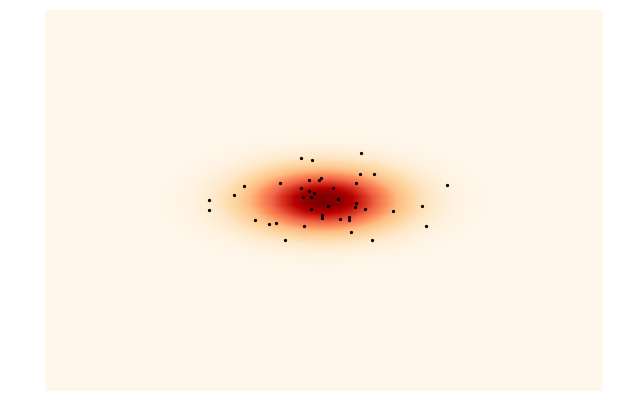

In [9]:
pca = PCA(n_components=2)
zero_transformation_pcs = pca.fit_transform(transformations[0])
pc_sigma = np.cov(zero_transformation_pcs, rowvar=False)

# Plot multivariate Gaussian with estimated parameters
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.
    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac / 2) / N

mean = np.array([0,0])
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mean, pc_sigma)
plt.figure(figsize = (10,7))
plt.contourf(X, Y, Z, 1000, cmap='OrRd', alpha=1)
plt.scatter(zero_transformation_pcs[:,0], zero_transformation_pcs[:,1], c='k', s=5)
plt.axis('off')

print('This cell plots the estimated thetas and the fitted Gaussian.')
hide_toggle()

# 3. Augment dataset by sampling transformations and applying them

Now that we have aligned the time series and built a statistical model over them we can actually perform our data augmentation. To do that, we pick a time series uniformly at random and sample a transformation from the fitted Gaussian. This process can be repeated arbitrarily often to produce an theoretically infinite amount of new data. Below, we plot the general trend of new datapoints in an animation showing the first prinicpal component of variation (see animation) as well as just one sample (plot).

In [10]:
def generate_new_data(T, sigma, X_train, indices, N_step=100, N_p=10):
    train_size, ts_length = X_train.shape
    # Sample new transformation from Gaussian distribution
    theta_new = np.random.multivariate_normal(mean=np.zeros(N_p - 1), cov=sigma)
    theta_new = theta_new.reshape((1, N_p - 1))
    # Sample a data point from uniform distribution
    i = random.randint(0, train_size-1)
    x_i = X_train[i]
    source = np.expand_dims(np.expand_dims(x_i, 0), 2)
    # Transform time series
    new_point = T.transform_data(source, theta_new)
    return new_point, indices[i], theta_new


def augment_dataset(X, y, theta_classes, sigmas, which):
    if which == 'training':
        nr_augment = 1000
    if which == 'val':
        nr_augment = 300
    train_size, ts_length = X.shape
    theta_len = theta_classes[list(theta_classes.keys())[0]].shape[1]
    T = cpab(tess_size=[10], return_tf_tensors=False, zero_boundary=True)
    T.fix_data_size([ts_length, 1])
    augmented_indices = np.empty(nr_augment)
    aug_thetas = np.empty((nr_augment, theta_len))
    X_augmented = np.empty((train_size + nr_augment, ts_length))
    X_augmented[:train_size, :] = X
    y_augmented = np.empty((train_size + nr_augment, 1))
    y_augmented[:train_size, :] = y.reshape((len(y), 1))
    augmented_data_set = {}
    idx = 0
    start = time.time()
    valid_classes = list(np.unique(y))
    _, X_classes, index_lookup = make_class_lookup(X, y)
    while idx < nr_augment:
        class_idx = random.choice(list(valid_classes))
        # Generate new data point
        new_data, old_ix, aug_theta = generate_new_data(T, sigmas[class_idx], X_classes[class_idx],
                                                          index_lookup[class_idx])
        # Save new point and original index
        augmented_indices[idx] = old_ix
        X_augmented[train_size + idx, :] = new_data.flatten()
        y_augmented[train_size + idx] = class_idx

        idx += 1
    return X_augmented, y_augmented.astype(int), augmented_indices.astype(int), aug_thetas

print('This cell contains functions for the actual augmentation.')
hide_toggle()

This cell contains functions for the actual augmentation.


In [11]:
X_train_aug, y_train_aug, augmented_indices, _ = augment_dataset(data['X_train'], data['y_train'], transformations, sigmas, which='training')

<IPython.core.display.Javascript object>


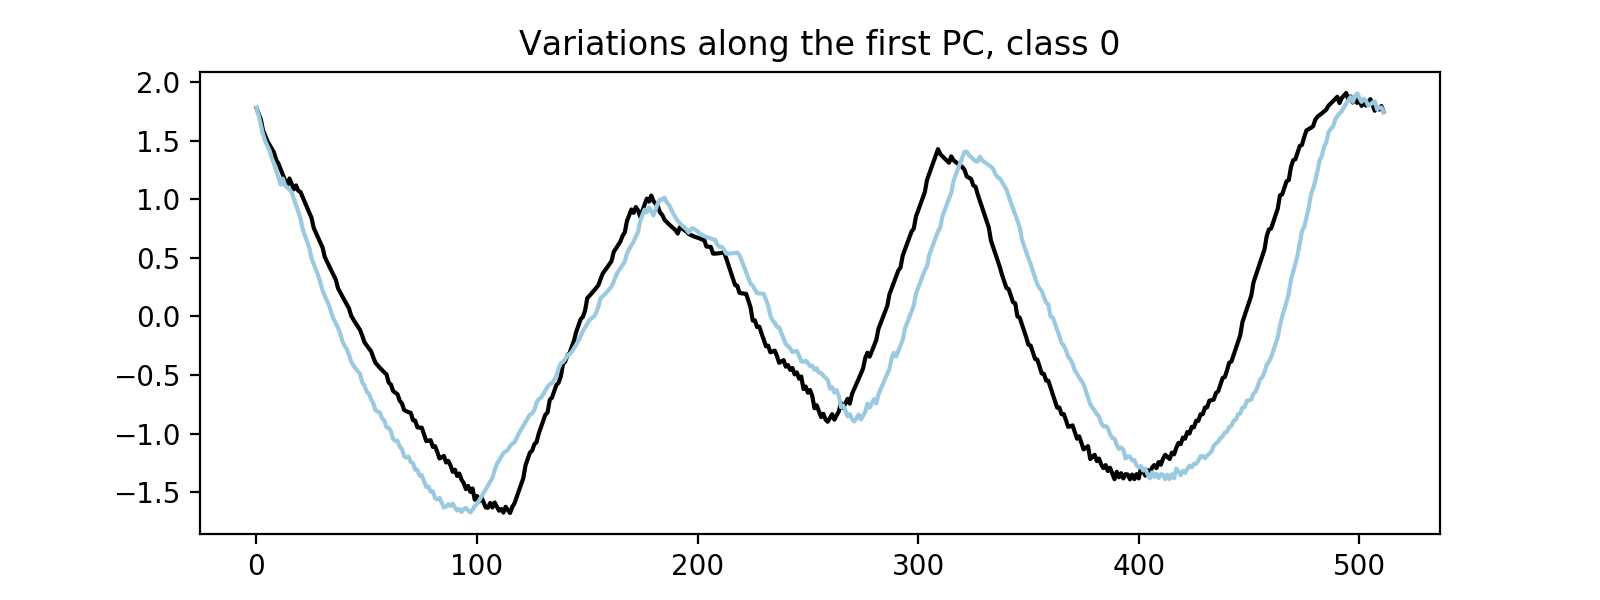

This cell produces an animation of the first principal components that we learn for class 0.


In [22]:
%matplotlib nbagg

th_class = 0

ts_length = data['X_train'].shape[1]
T = cpab(tess_size=[10], return_tf_tensors=False, zero_boundary=True)

pca = PCA(n_components=1)
pca.fit(sigmas[th_class])
data_point_here_ix = np.where(data['y_train'] == th_class)[0][0]
data_point_here = np.expand_dims(np.expand_dims(data['X_train'][data_point_here_ix, :], 0), 2)
pc = pca.components_
eigval = pca.singular_values_
fig, ax = plt.subplots(1, figsize = (8, 3))
ax.plot(data_point_here.flatten(), label = 'source', color='k')
ax.set_title(label='Variations along the first PC, class %s' %th_class)

plots = []
cm_subsection = np.linspace(0, 1, 20)
colors = [plt.cm.RdBu(x) for x in cm_subsection ]

for i, factor in enumerate(range(0, 20)):
    theta = pc*math.sin(((factor/10)*math.pi))
    theta = theta.reshape((1, -1))
    new_point = T.transform_data(data_point_here, theta)
    plots.append(ax.plot(new_point.flatten(), label = 'source', animated= True, color=colors[i]))

ani = animation.ArtistAnimation(fig, plots, interval=100, blit=True,
                                repeat_delay=100)
writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('test.mp4', writer=writer)

print('''This cell produces an animation of the first principal components that we learn for class 0.
Warning: This plotting is sloooow.''')
hide_toggle()

In [ ]:
# PCA plot, delete and replace by video
th_class = 0
ts_length = data['X_train'].shape[1]
T = cpab(tess_size=[10], return_tf_tensors=False, zero_boundary=True)

cm_subsection = np.linspace(0, 1, 4)
colors = [plt.cm.RdBu(x) for x in cm_subsection ]

pca = PCA(n_components=1)
pca.fit(sigmas[th_class])
data_point_here_ix = np.where(data['y_train'] == th_class)[0][0]
data_point_here = np.expand_dims(np.expand_dims(data['X_train'][data_point_here_ix, :], 0), 2)
pc = pca.components_
eigval = pca.singular_values_[0]
fig, ax = plt.subplots(1, figsize = (15, 5))
ax.set_title(label='Variations along the first PC, class %s' %th_class)

for i, factor in enumerate([-3,-1.5,1.5,3]):
    theta = pc*factor
    theta = theta.reshape((1, -1))
    new_point = T.transform_data(data_point_here, theta)
    ax.plot(new_point.flatten(), color=colors[i])
    
ax.plot(data_point_here.flatten(), label = 'source', color='k')

In [10]:
HTML("""
<video width="320" height="240" controls>
  <source src="test.mp4" type="video/mp4">
</video>
""")

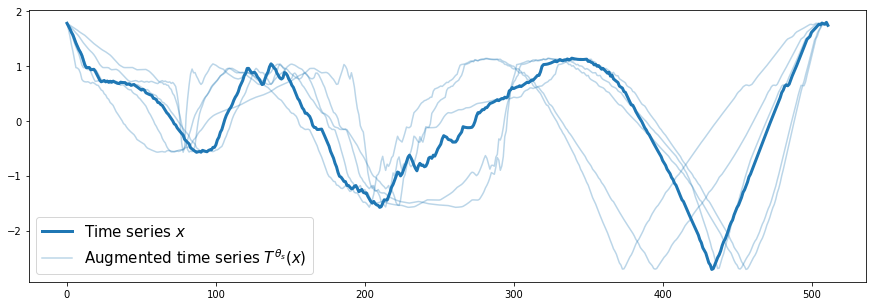

In [89]:
# Example augmentation for paper (delete??!)
%matplotlib inline
fig, ax = plt.subplots(1, figsize = (15, 5))
ax.plot(data['X_train'][1, :].flatten(), label = 'Time series $x$', c='C0', linewidth=3)
#ax.plot(X_train_aug[len(data['X_train']) + 29,:], label = 'augmented datapoint')
ax.plot(X_train_aug[len(data['X_train']) + 51,:], label = r'Augmented time series $T^{\theta_s}(x)$', c='C0', alpha=0.3)
ax.plot(X_train_aug[len(data['X_train']) + 63,:],  c='C0', alpha=0.3)
#ax.plot(X_train_aug[len(data['X_train']) + 64,:], label = 'augmented datapoint',  c='b', alpha=0.5)
ax.plot(X_train_aug[len(data['X_train']) + 149,:],  c='C0', alpha=0.3)
ax.plot(X_train_aug[len(data['X_train']) + 244,:],  c='C0', alpha=0.3)
ax.plot(X_train_aug[len(data['X_train']) + 327,:],  c='C0', alpha=0.3)

plt.legend(fontsize=15);
plt.savefig('augmentations.pdf',format='pdf');

# 3. Train a 1-nearest-neighbor classifier

After we augment the data set in the way described above, we use it in a 1-nearest-neighbor classifier. We than compare classification performance with and without data augmentation.

In [50]:
def predict(X_train, X_test, y_train, y_test):
    # Train 1NN classifier
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train, y_train)

    # Classify
    y_pred = neigh.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    err_rate = 1 - acc
    return err_rate

print('This cell contains the code for the 1-nearest-neighbour classifier.')
hide_toggle()

This cell contains the code for the 1-nearest-neighbour classifier.


### Experiment:
Compare 1-nearest-neighbor classifier with and without data augmentation.

In [62]:
err_rate_non_augmented = predict(data['X_train'], data['X_test'], data['y_train'], data['y_test'])

In [57]:
err_rate_augmented = predict(X_train_aug, data['X_test'], y_train_aug.flatten(), data['y_test'])

In [61]:
relative_improvement = np.round(((err_rate_non_augmented - err_rate_augmented)/err_rate_non_augmented)*100, 2)
print("""The learned data augmentation scheme yielded an error rate improvement from %s to %s. That's a relative improvement by %s percent.""" 
      %(err_rate_non_augmented, err_rate_augmented, relative_improvement))

The learned data augmentation scheme yielded an error rate improvement from 0.35 to 0.25. That's a relative improvement by 28.57 percent.
